In [1]:
!pip install --quiet torchio==0.18.90
!pip install --quiet pandas matplotlib seaborn scikit-image
!curl -sS -O https://raw.githubusercontent.com/fepegar/highresnet/master/GIFNiftyNet.ctbl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.7/172.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:

from functools import partialmethod
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torchio as tio
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm, trange


torch.manual_seed(0)
torch.set_grad_enabled(False)
figsize = 16, 9
tio.Subject.plot = partialmethod(tio.Subject.plot, figsize=figsize, reorient=False)

print('TorchIO version:', tio.__version__)


TorchIO version: 0.18.90


In [3]:
root_dir = Path('data')
tio.download.download_and_extract_archive(
    'https://github.com/NifTK/NiftyNetModelZoo/raw/5-reorganising-with-lfs/highres3dnet_brain_parcellation/data.tar.gz',
    root_dir
)
mri_path = list(root_dir.glob('*.nii.gz'))[0]
mri_path

6602752it [00:00, 10605271.75it/s]         


PosixPath('data/OAS1_0145_MR2_mpr_n4_anon_sbj_111.nii.gz')

In [4]:
subject_oasis = tio.Subject(t1=tio.ScalarImage(mri_path))
subject = subject_oasis

In [5]:
transforms = [
    tio.ToCanonical(),
    tio.Resample(1),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.Crop((0, 0, 10, 30, 40, 40)),
]
transform = tio.Compose(transforms)
preprocessed = transform(subject)

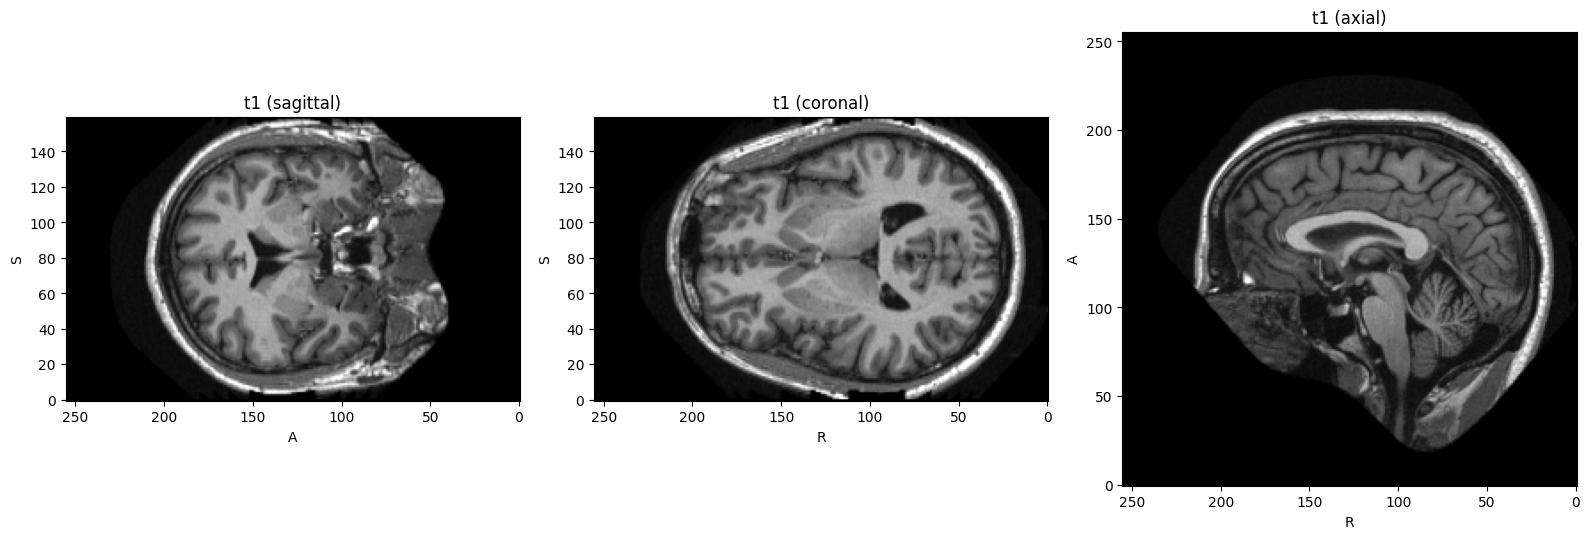

In [6]:
subject.plot()

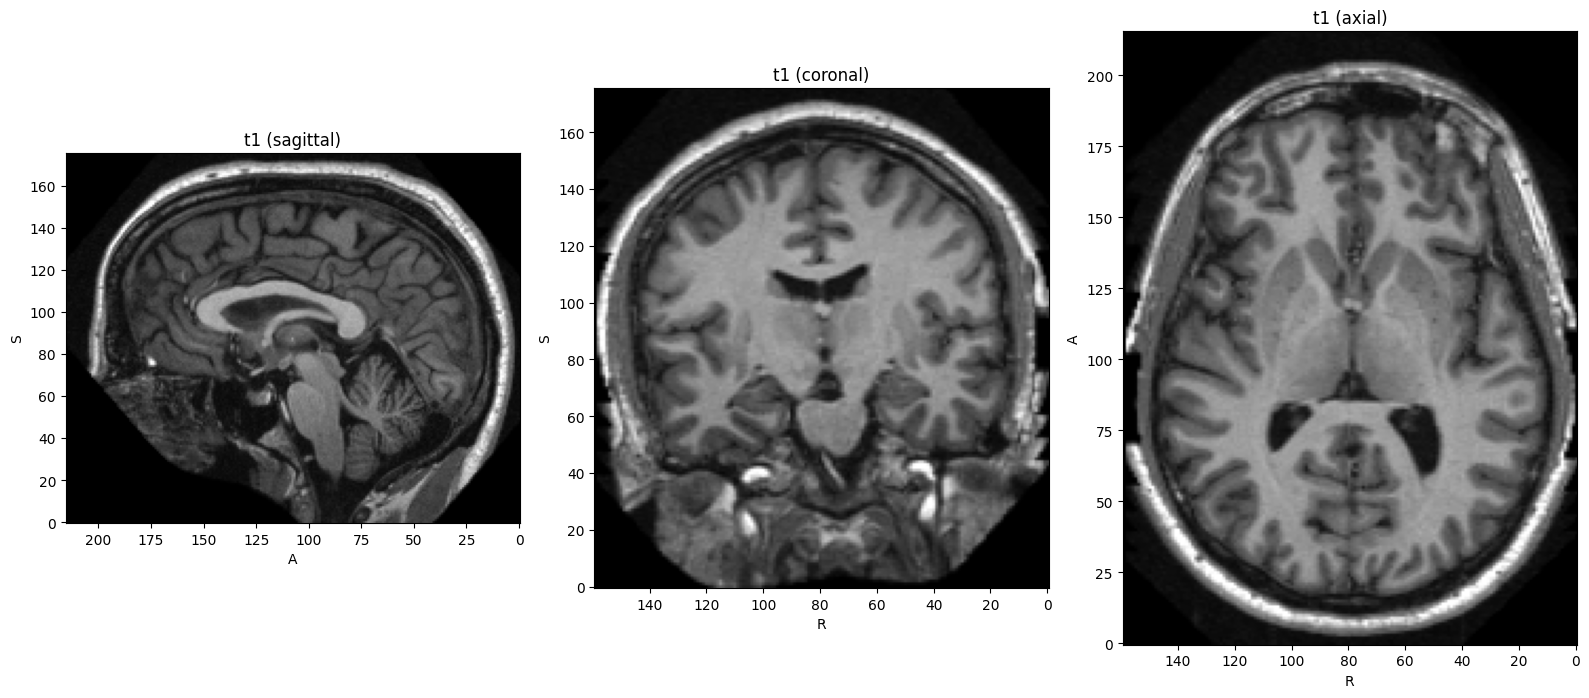

In [7]:
preprocessed.plot()

In [8]:
repo = 'fepegar/highresnet'
model_name = 'highres3dnet'
model = torch.hub.load(repo, model_name, pretrained=True, trust_repo=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
model.to(device).eval();

Downloading: "https://github.com/fepegar/highresnet/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/fepegar/highresnet-models/raw/master/highres3dnet_li_parameters-7d297872.pth" to /root/.cache/torch/hub/checkpoints/highres3dnet_li_parameters-7d297872.pth


Device: cpu


In [9]:
# Some tools for visualization
class ColorMapHelper:
    def __init__(self, colors_path):
        columns = 'name', *'rgba'
        df = pd.read_csv(colors_path, sep=' ', header=None, index_col=0, names=columns)
        max_index = max(df.index)
        self.cmap_data = np.zeros((max_index + 1, 4))
        df[['r', 'g', 'b', 'a']] = df[['r', 'g', 'b', 'a']] / 255
        self.cmap_data[df.index] = df[['r', 'g', 'b', 'a']].values
        self.cmap_data[:, 3] = 1
        self.cmap = ListedColormap(self.cmap_data)
helper = ColorMapHelper('GIFNiftyNet.ctbl')
cmap = helper.cmap
cmap_dict = {}

Using device: cpu
Input tensor shape: torch.Size([1, 1, 160, 216, 176])
Segmentation tensor shape: torch.Size([1, 160, 216, 176])


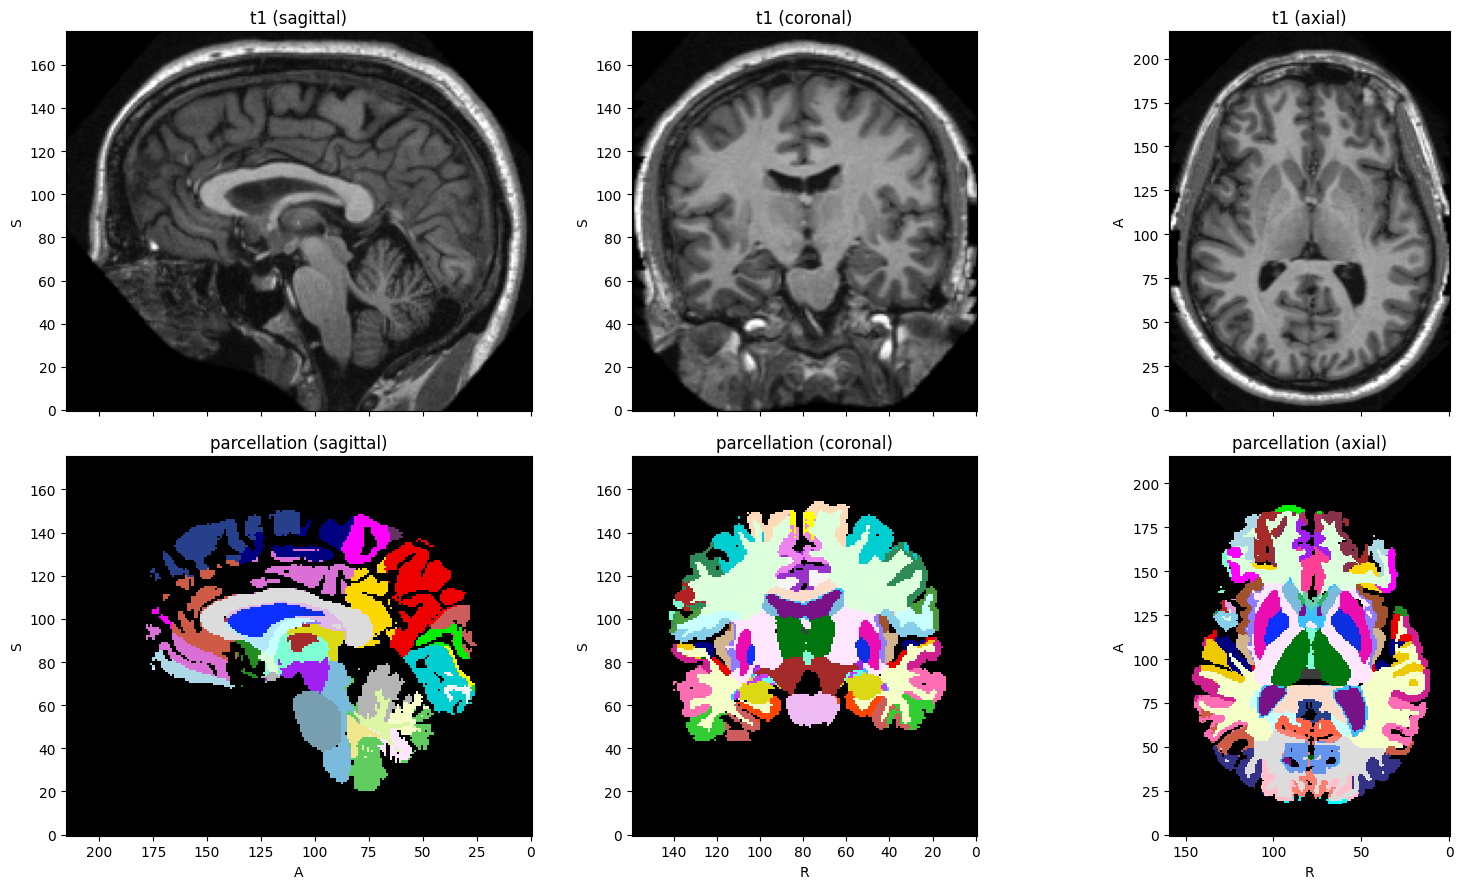

In [10]:

device = torch.device("cpu")
print("Using device:", device)
input_tensor = preprocessed.t1.data.unsqueeze(0).to(device)
print("Input tensor shape:", input_tensor.shape)
with torch.no_grad():
    logits = model(input_tensor)
full_volume_output_tensor = logits.argmax(dim=tio.CHANNELS_DIMENSION, keepdim=True).cpu()[0]
print("Segmentation tensor shape:", full_volume_output_tensor.shape)
seg = tio.LabelMap(tensor=full_volume_output_tensor, affine=preprocessed.t1.affine)
name = "parcellation"
preprocessed.add_image(seg, name)
cmap_dict[name] = cmap
try:
    preprocessed.plot(cmap_dict=cmap_dict)
except Exception as e:
    print(f"Plotting error: {e}")
    seg.plot()


In [11]:
def get_lr_remapping(table_path):
    import pandas as pd
    df = pd.read_csv(table_path, sep=' ', names=['Label', 'Name', *'RGBA'])
    mapping = {}
    for row in df.itertuples():
        if 'Left' in row.Name:
            mapping[row.Label] = df[df.Name == f'Right-{row.Name[5:]}'].Label.values[0]
        elif 'Right' in row.Name:
            mapping[row.Label] = df[df.Name == f'Left-{row.Name[6:]}'].Label.values[0]
    return mapping

In [12]:
import pandas as pd

def get_lr_remapping(table_path):
    """
    This function reads a brain region label table and creates a mapping between left and right hemisphere regions.

    Args:
        table_path (str): Path to the CSV file containing brain region labels.

    Returns:
        dict: A dictionary mapping left-region labels to right-region labels and vice versa.
    """
    # Load only necessary columns (reduces memory usage)
    df = pd.read_csv(table_path, sep=' ', names=['Label', 'Name', 'R', 'G', 'B', 'A'], usecols=['Label', 'Name'])

    # Create a dictionary for quick lookup: {Region Name → Label ID}
    name_to_label = dict(zip(df["Name"], df["Label"]))

    mapping = {}  # Dictionary to store left-right mappings

    for name, label in name_to_label.items():
        if "Left" in name:
            right_name = f"Right-{name[5:]}"  # Convert "Left-" to "Right-"
            if right_name in name_to_label:
                mapping[label] = name_to_label[right_name]

        elif "Right" in name:
            left_name = f"Left-{name[6:]}"  # Convert "Right-" to "Left-"
            if left_name in name_to_label:
                mapping[label] = name_to_label[left_name]

    return mapping


# Example Usage
if __name__ == "__main__":
    table_path = "GIFNiftyNet.ctbl"  # Change this to your actual file path
    lr_mapping = get_lr_remapping(table_path)

    print("Left-Right Brain Region Mapping:")
    print(lr_mapping)  # Prints the mapping of left and right labels


Left-Right Brain Region Mapping:
{8: 9, 9: 8, 10: 11, 11: 10, 14: 15, 15: 14, 16: 17, 17: 16, 18: 19, 19: 18, 23: 24, 24: 23, 25: 26, 26: 25, 27: 28, 28: 27, 29: 30, 30: 29, 31: 32, 32: 31, 33: 34, 34: 33, 35: 36, 36: 35, 37: 38, 38: 37, 39: 40, 40: 39, 45: 46, 46: 45, 47: 54, 48: 55, 49: 56, 50: 57, 51: 58, 52: 59, 54: 47, 55: 48, 56: 49, 57: 50, 58: 51, 59: 52, 60: 61, 61: 60, 62: 63, 63: 62, 64: 65, 65: 64, 66: 67, 67: 66, 68: 69, 69: 68, 70: 71, 71: 70, 72: 73, 73: 72, 74: 75, 75: 74, 76: 77, 77: 76, 78: 79, 79: 78, 80: 81, 81: 80, 82: 83, 83: 82, 84: 85, 85: 84, 86: 87, 87: 86, 88: 89, 89: 88, 90: 91, 91: 90, 92: 93, 93: 92, 94: 95, 95: 94, 96: 97, 97: 96, 98: 99, 99: 98, 100: 101, 101: 100, 102: 103, 103: 102, 104: 105, 105: 104, 106: 107, 107: 106, 108: 109, 109: 108, 110: 111, 111: 110, 112: 113, 113: 112, 114: 115, 115: 114, 116: 117, 117: 116, 118: 119, 119: 118, 120: 121, 121: 120, 122: 123, 123: 122, 124: 125, 125: 124, 126: 127, 127: 126, 128: 129, 129: 128, 130: 131, 131: